In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Conv2DTranspose, Flatten, LeakyReLU, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from IPython.display import clear_output
%matplotlib inline

In [2]:
"""
Linux Paths for CheXpert Dataset

train_dir = os.path.abspath("/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv")
traindf=pd.read_csv(train_dir, dtype=str)

valid_dir = os.path.abspath("/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
validdf=pd.read_csv(valid_dir, dtype=str)

for i in range(len(traindf)):
    traindf.iloc[i,0] = "/media/nicholasjprimiano/8A5C72285C720F67/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + traindf.iloc[i,0]"""
    
#Windows Paths for CheXpert Dataset

train_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv")
traindf=pd.read_csv(train_dir, dtype=str)

#Modify dataframe path
for i in range(len(traindf)):
    traindf.iloc[i,0] = r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/" + traindf.iloc[i,0]

#valid_dir = os.path.abspath(r"C:/ML_C/CheXpert/CheXpert-Keras-master/data/default_split/CheXpert-v1.0-small/CheXpert-v1.0-small/valid.csv")
#validdf=pd.read_csv(valid_dir, dtype=str)

In [3]:
#Only looking at AP (anterior-posterior) view xrays
aptrainlist = []
for i in range(len(traindf)):
    if (traindf.iloc[i,4] == "AP"):
        aptrainlist.append(traindf.iloc[i,:])

aptraindf = pd.DataFrame(aptrainlist)

#Only looking at xrays labled Pneumothorax
paths = []
for i in range(len(aptraindf[aptraindf["Pneumothorax"] == "1.0"]["Path"])):
    paths.append(aptraindf[aptraindf["Pneumothorax"] == "1.0"]["Path"].iloc[i])

In [4]:
#Normalization called in get_imgs() not used right now
def normalize_xray(img):
    hist_normal = exposure.equalize_adapthist(img/np.max(img))   
    clash_hist_normal = exposure.equalize_adapthist(hist_normal /np.max(hist_normal))
    return clash_hist_normal

In [5]:
#load 128x128 images

IMG_SIZE = 128
def get_imgs(paths):
    images = []
    for i in paths:
        #Normalized
        #images.append(normalize_xray(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY)))
        #Gray Scale 
        images.append(cv2.cvtColor(cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)), cv2.COLOR_BGR2GRAY))
    return images 

In [6]:
#X_train array of images with values between 0 and 1
X_train = np.array(get_imgs(paths)).astype(np.float32)/255

In [7]:
#reshaped X train and shifted pixzel values between -1 and 1 for tanh 
X_train_dcgan = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1) * 2. - 1.

In [8]:
"""tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 1024, input_shape=[codings_size], activation="relu"),
    keras.layers.Reshape([8, 8, 1024]),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding="SAME",activation="relu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="SAME",activation="relu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",activation="relu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",activation="relu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, kernel_size=5, strides=1, padding="SAME",
                                 activation="tanh"),
])
generator.summary()"""

'tf.random.set_seed(42)\nnp.random.seed(42)\n\ncodings_size = 100\n\ngenerator = keras.models.Sequential([\n    keras.layers.Dense(8 * 8 * 1024, input_shape=[codings_size], activation="relu"),\n    keras.layers.Reshape([8, 8, 1024]),\n    keras.layers.ReLU(),\n    keras.layers.BatchNormalization(),\n\n    keras.layers.Conv2DTranspose(512, kernel_size=5, strides=2, padding="SAME",activation="relu"),\n    keras.layers.BatchNormalization(),\n\n    keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding="SAME",activation="relu"),\n    keras.layers.BatchNormalization(),\n\n    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",activation="relu"),\n    keras.layers.BatchNormalization(),\n\n    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",activation="relu"),\n    keras.layers.BatchNormalization(),\n\n    keras.layers.Conv2D(1, kernel_size=5, strides=1, padding="SAME",\n                                 activation="tanh"),\n])\nge

In [9]:
"""tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 128]),

    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="SAME",
                                 activation="relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="relu"),
    keras.layers.Dropout(0.5),
                                 
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
generator.summary()


discriminator = keras.models.Sequential([

    keras.layers.Conv2D(64, kernel_size=5, strides=1, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[128, 128, 1]),
    
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()"""

"""
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[128, 128, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
"""

'\ndiscriminator = keras.models.Sequential([\n    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",\n                        activation=keras.layers.LeakyReLU(0.2),\n                        input_shape=[128, 128, 1]),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",\n                        activation=keras.layers.LeakyReLU(0.2)),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="SAME",\n                        activation=keras.layers.LeakyReLU(0.2)),\n    keras.layers.BatchNormalization(),\n    keras.layers.Flatten(),\n    keras.layers.Dense(1, activation="sigmoid")\n])\n'

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([

    keras.layers.Dense(128 * 32* 32, activation="relu", input_shape=[codings_size]),
    keras.layers.Reshape((32,32, 128)),
    keras.layers.UpSampling2D(),
    
    keras.layers.GaussianNoise(stddev=1),
    keras.layers.Conv2D(128, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Activation("relu"),
    keras.layers.UpSampling2D(),
    
    keras.layers.GaussianNoise(stddev=1),
    keras.layers.Conv2D(64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(1, kernel_size=3, padding="same"),
    keras.layers.Activation("tanh")

])
generator.summary()

discriminator = keras.models.Sequential([
    
    keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[128, 128, 1], padding="same"),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
    keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
    BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 131072)            13238272  
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 gaussian_noise (GaussianNoi  (None, 64, 64, 128)      0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      5

In [12]:
gan = keras.models.Sequential([generator, discriminator])

In [13]:
def label_smoothing(y_true,y_pred):
     return tf.keras.losses.binary_crossentropy(y_true,y_pred, label_smoothing=0.2)

In [14]:
discriminator.compile(loss=label_smoothing, optimizer=tf.keras.optimizers.Adam(beta_1 = 0.0002, beta_2 = 0.7), metrics=[tf.keras.metrics.Accuracy()])
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="Adam")

#changed from 128 - smaller batches seem to yeild better results
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(250)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [15]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=500):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))   
           
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
            
        if epoch % 5 == 0:
            clear_output(wait=True)

        print("g_loss", g_loss)  
        print("d_loss", d_loss) 
        
        plt.imshow(generator(noise)[0,:,:,:] + 1, cmap="gray")
        #print(str(generator(noise)[0,:,:,:]))
        plt.show()


In [16]:
"""
#Bad attempt at splitting up fake and real batchs

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=500):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))   
           
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)    

            # generate 'fake' examples
            X_fake = generated_images
            y_fake = tf.constant([[0.]] * batch_size)

            X_real =  X_batch
            y_real = tf.constant([[1.]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_real, y_real)
            # update discriminator model weights
            d_loss = discriminator.train_on_batch(X_fake, y_fake)


            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        if epoch % 5 == 0:
            clear_output(wait=True)

        print("g_loss", g_loss)  
        print("d_loss", d_loss) 
        plt.imshow(generator(noise)[0,:,:,:] + 1, cmap="gray")
        #print(str(generator(noise)[0,:,:,:]))
        plt.show()"""

'\n#Bad attempt at splitting up fake and real batchs\n\ndef train_gan(gan, dataset, batch_size, codings_size, n_epochs=500):\n    generator, discriminator = gan.layers\n    \n    for epoch in range(n_epochs):\n        print("Epoch {}/{}".format(epoch + 1, n_epochs))   \n           \n        for X_batch in dataset:\n            # phase 1 - training the discriminator\n            noise = tf.random.normal(shape=[batch_size, codings_size])\n            generated_images = generator(noise)    \n\n            # generate \'fake\' examples\n            X_fake = generated_images\n            y_fake = tf.constant([[0.]] * batch_size)\n\n            X_real =  X_batch\n            y_real = tf.constant([[1.]] * batch_size)\n\n            discriminator.trainable = True\n            discriminator.train_on_batch(X_real, y_real)\n            # update discriminator model weights\n            d_loss = discriminator.train_on_batch(X_fake, y_fake)\n\n\n            # phase 2 - training the generator\n       

g_loss 3.8943500868526826e-08
d_loss [0.4024612307548523, 0.0]


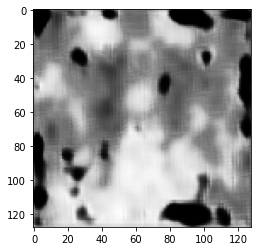

Epoch 2/500


In [17]:
train_gan(gan, dataset, batch_size, codings_size)